In [2]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import readligo as rl

In [3]:
epochs = 50
test_sample_ratio = .2
input_vector_length = 1024
batch_size = 200
num_bins = 40

input_dir = "/Volumes/Research/GWNMMAD_data/Downsampled/V1/"
input_file_list = ["H-H1_GWOSC_O2_4KHZ_R1-1174978560-4096_downsampled", "L-L1_GWOSC_O2_4KHZ_R1-1187291136-4096_downsampled", "V-V1_GWOSC_O2_4KHZ_R1-1187688448-4096_downsampled"]

input_file = input_file_list[1]

output_dir  = "/Volumes/Research/GWNMMAD_data/Model/"

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1024, 768),
            nn.ReLU(),
            nn.Linear(768, 384),
            nn.ReLU(),

        )
        self.decoder = nn.Sequential(
            nn.Linear(384, 768),
            nn.ReLU(),
            nn.Linear(768, 1024),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [5]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm, norm, 0

In [6]:
def min_max_normalization(v):
    coef = max(v)-min(v)
    minimal = min(v)
    v = (v - min(v)) / ( max(v) - min(v) )
    return v, minimal, coef

In [18]:
def bunch_normalize(v_set):
    recover_min = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    for i in range(len(v_set)):
        v_set[i], recover_min[i], recover_coef[i] = min_max_normalization(v_set[i])
    return v_set, recover_min, recover_coef

In [22]:
data = np.load("/Users/Liyang_Miao/Library/CloudStorage/OneDrive-HKUSTConnect/Research/GWNMMAD/Data——cached/LIGO_noise_data_downsampled_whitened_bandpassed.npy").reshape(-1, 1024)

assert data.shape[1] == input_vector_length

total_sample_number = data.shape[0]
test_sample_number = int(test_sample_ratio * total_sample_number)
train_sample_number = total_sample_number-test_sample_number


X_train = data[0:train_sample_number-1]
X_test = data[-test_sample_number:]

X_train, X_train_recover_min, X_train_recover_coef = bunch_normalize(X_train)
X_test, X_test_recover_min, X_test_recover_coef = bunch_normalize(X_test)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

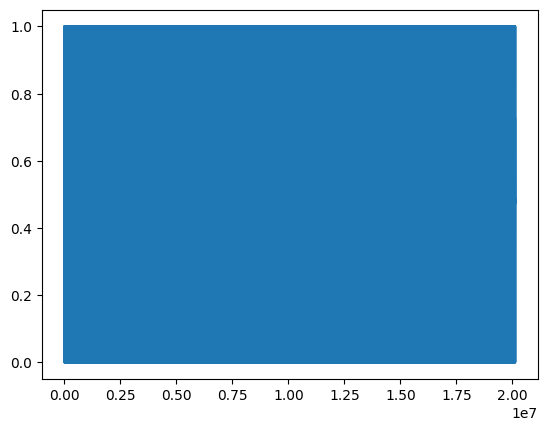

In [20]:
plt.plot(X_train.flatten())

In [21]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)


train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


autoencoder = AutoEncoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
loss_func = nn.MSELoss()
loss_train = np.zeros((epochs, 1))


for epoch in range(epochs):
    for batchidx, (x, _) in enumerate(trainDataLoader):
        encoded, decoded = autoencoder(x)
        loss = loss_func(decoded, x) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
           
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item()))

Epoch: 0001, Training loss=0.02465911
Epoch: 0002, Training loss=0.02424543
Epoch: 0003, Training loss=0.02409019
Epoch: 0004, Training loss=0.02355460
Epoch: 0005, Training loss=0.02447372
Epoch: 0006, Training loss=0.02388093
Epoch: 0007, Training loss=0.02445275
Epoch: 0008, Training loss=0.02375820
Epoch: 0009, Training loss=0.02406778
Epoch: 0010, Training loss=0.02360117
Epoch: 0011, Training loss=0.02237520
Epoch: 0012, Training loss=0.02382359
Epoch: 0013, Training loss=0.02328575
Epoch: 0014, Training loss=0.02364586
Epoch: 0015, Training loss=0.02347452
Epoch: 0016, Training loss=0.02281903
Epoch: 0017, Training loss=0.02334849
Epoch: 0018, Training loss=0.02307364
Epoch: 0019, Training loss=0.02256726
Epoch: 0020, Training loss=0.02332245
Epoch: 0021, Training loss=0.02310302
Epoch: 0022, Training loss=0.02141077
Epoch: 0023, Training loss=0.02260088
Epoch: 0024, Training loss=0.02208370
Epoch: 0025, Training loss=0.02366791
Epoch: 0026, Training loss=0.02150646
Epoch: 0027,

NameError: name 'loss_train' is not defined

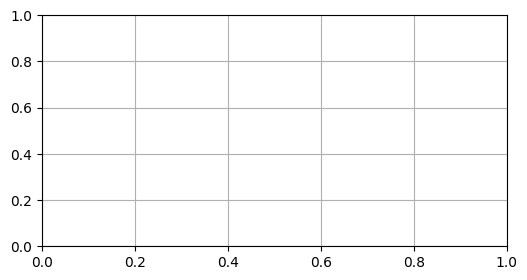

In [9]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2)    
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 5 layer AE, L bkg')
plt.show()

In [200]:
_, decodedTestdata = autoencoder(trainData)
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError_train = torch.mean((trainData - reconstructedData)**2,dim=1)
MAE_train = ReconstructedError_train.mean()

Text(0, 0.5, 'Strain')

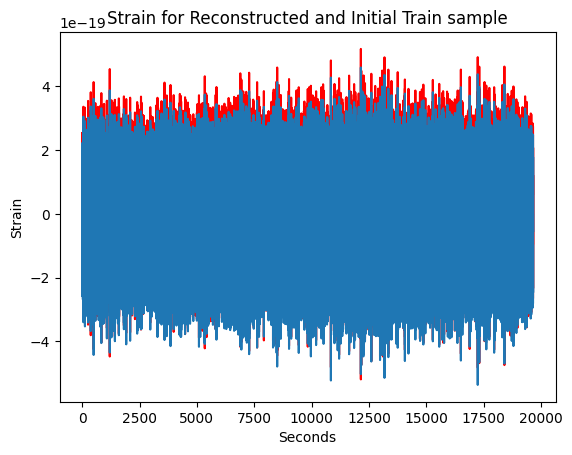

In [189]:
data = np.reshape(pd.read_csv(input_dir + input_file + ".csv", header=None)[0].to_numpy(), (-1, input_vector_length))
x = np.arange(0, train_sample_number-1, 1/1024)
plt.plot(x, data[0:train_sample_number-1].flatten(), color = 'red')
y = np.zeros((train_sample_number-1, 1024))
for i in range(train_sample_number-1):
    y[i] = reconstructedData[i] * X_train_recover_coef[i] + X_train_recover_min[i]
plt.plot(x, y.flatten())
plt.title('Strain for Reconstructed and Initial Train sample')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [192]:
MAE.numpy()

array(0.00057204)

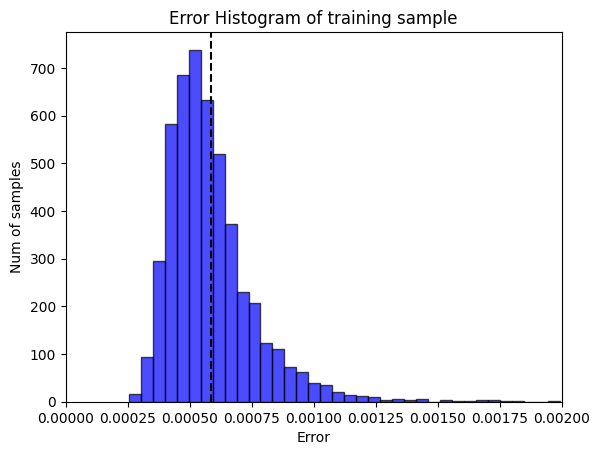

In [197]:
plt.hist(ReconstructedError_train, bins=55,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample')
plt.xlim(0,0.0020)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MAE_train, color = 'black', linestyle = '--')
plt.show()

In [201]:
_, decodedTestdata = autoencoder(testData)
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError_test = torch.mean((testData - reconstructedData)**2,dim=1)
MAE_test = ReconstructedError_test.mean()

Text(0, 0.5, 'Strain')

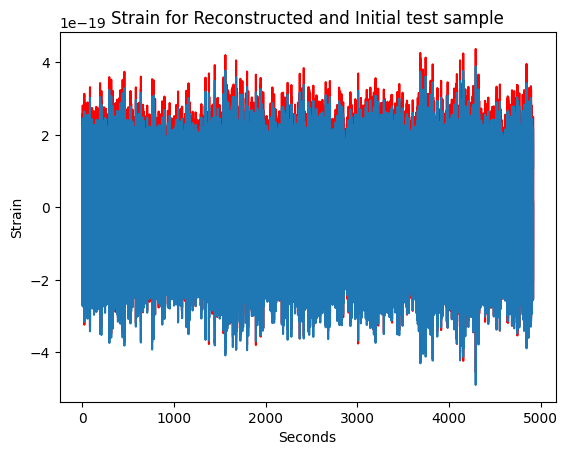

In [194]:
data = np.reshape(pd.read_csv(input_dir + input_file + ".csv", header=None)[0].to_numpy(), (-1, input_vector_length))
x = np.arange(0, 4915, 1/1024)
plt.plot(x, data[-test_sample_number:].flatten(), color = 'red')
for i in range(4915):
    reconstructedData[i] = reconstructedData[i] * X_test_recover_coef[i] + X_test_recover_min[i]
plt.plot(x, (reconstructedData).flatten())
plt.title('Strain for Reconstructed and Initial test sample')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [199]:
MAE.numpy()

array(0.00058588)

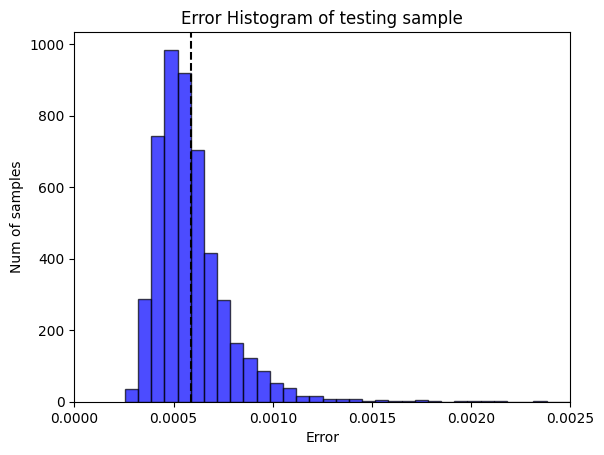

In [195]:

plt.hist(ReconstructedError_test, bins=num_bins,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of testing sample')
plt.xlim(0,0.0025)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MAE_test, color = 'black', linestyle = '--')
plt.show()

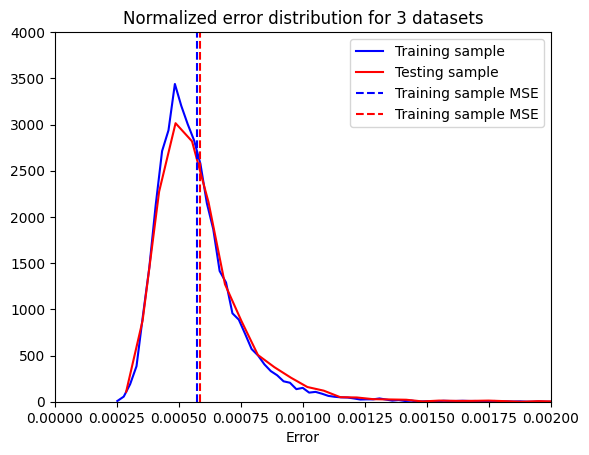

In [208]:
counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = 140, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = 40, density = True)
bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
plt.plot(bin_centers_train, counts_train, color = 'blue', label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = 'red', label = 'Testing sample')
plt.axvline(x = MAE_train, color = 'blue', linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MAE_test, color = 'red', linestyle = '--', label = 'Training sample MSE')
plt.xlim(0, 0.002)
plt.ylim(0, 4000)
plt.xlabel('Error')
plt.title('Normalized error distribution for 3 datasets')
plt.legend()
plt.show()

In [79]:
ReconstructedError

tensor([0.0026, 0.0024, 0.0019, 0.0015, 0.0018, 0.0014, 0.0011, 0.0018, 0.0037,
        0.0016, 0.0018, 0.0035, 0.0038, 0.0022, 0.0025, 0.0026, 0.0018, 0.0016,
        0.0019, 0.0015, 0.0015, 0.0011, 0.0014, 0.0016, 0.0019, 0.0010, 0.0015,
        0.0013, 0.0011, 0.0015, 0.0030, 0.0025, 0.0016, 0.0014, 0.0024, 0.0018,
        0.0013, 0.0008, 0.0033, 0.0026, 0.0018, 0.0013, 0.0016, 0.0013, 0.0014,
        0.0011, 0.0013, 0.0019, 0.0012, 0.0012, 0.0011, 0.0018, 0.0019, 0.0023,
        0.0019, 0.0028, 0.0021, 0.0021, 0.0027, 0.0059, 0.0020, 0.0017, 0.0012,
        0.0026, 0.0054, 0.0012, 0.0008, 0.0031, 0.0023, 0.0021, 0.0025, 0.0017,
        0.0020, 0.0018, 0.0011, 0.0010, 0.0026, 0.0021, 0.0021, 0.0011, 0.0012,
        0.0016, 0.0013, 0.0019, 0.0021, 0.0010, 0.0026, 0.0023, 0.0028, 0.0019,
        0.0014, 0.0021, 0.0019, 0.0018, 0.0024, 0.0018, 0.0018, 0.0015, 0.0013,
        0.0010, 0.0013, 0.0017, 0.0019, 0.0010, 0.0020, 0.0020, 0.0030, 0.0021,
        0.0011, 0.0009, 0.0025, 0.0016, 

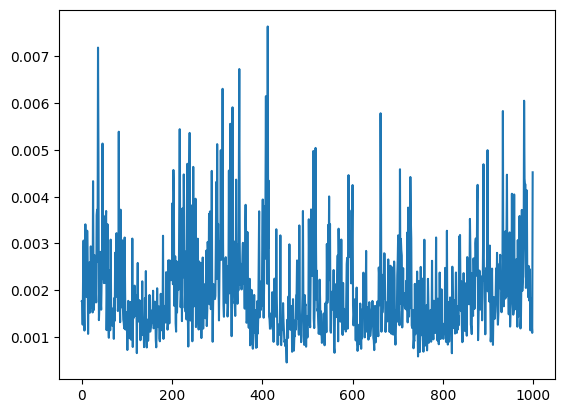

In [135]:
plt.plot(ReconstructedError)

In [40]:
strain, time, dq = rl.loaddata("/Volumes/Research/GWNMMAD_data/Test_Data/Injection_from_Ligo/L-L1_LOSC_4_V1-816996352-4096.hdf5")
strain_downsampled = []

average = 0
for j in (range(len(strain))):
    average += strain[j]
    
    if j%4 == 3:
        average = average / 4.
        strain_downsampled.append(average)
        average = 0

strain_downsampled = np.array(strain_downsampled).reshape(-1, 1024)

full_seconds = strain_downsampled.shape[0]
strain_downsampled_picked = strain_downsampled[np.argwhere(dq['DEFAULT'] == 1)].reshape(-1, 1024)
missing_seconds = full_seconds - strain_downsampled_picked.shape[0]


In [41]:
strain_downsampled_picked_normalized, junk1, junk2 = bunch_normalize(strain_downsampled_picked)

In [42]:
data = strain_downsampled_picked_normalized[1000:]

In [ ]:
assert data.shape[1] == 1024

total_sample_number = data.shape[0]
test_sample_number = int(test_sample_ratio*total_sample_number)
train_sample_number = total_sample_number-test_sample_number


X_train = data[0:train_sample_number-1]
X_test = data[-test_sample_number:]

X_train, X_train_recover_min, X_train_recover_coef = bunch_normalize(X_train)
X_test, X_test_recover_min, X_test_recover_coef = bunch_normalize(X_test)

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)


train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


In [56]:
assert data.shape[1] == 1024

total_sample_number = data.shape[0]
test_sample_number = int(test_sample_ratio*total_sample_number)
train_sample_number = total_sample_number-test_sample_number


X_train = data[0:train_sample_number-1]
X_test = data[-test_sample_number:]

X_train, X_train_recover_min, X_train_recover_coef = bunch_normalize(X_train)
X_test, X_test_recover_min, X_test_recover_coef = bunch_normalize(X_test)

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)


train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


autoencoder1 = AutoEncoder()
optimizer = optim.Adam(autoencoder1.parameters(), lr=1e-3)
loss_func = nn.MSELoss()
loss_train = np.zeros((epochs, 1))


for epoch in range(epochs):
    for batchidx, (x, _) in enumerate(trainDataLoader):
        encoded, decoded = autoencoder1(x)
        loss = loss_func(decoded, x) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
           
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item()))

Epoch: 0001, Training loss=0.07351834
Epoch: 0002, Training loss=0.05155592
Epoch: 0003, Training loss=0.04064704
Epoch: 0004, Training loss=0.02473589
Epoch: 0005, Training loss=0.02218299
Epoch: 0006, Training loss=0.02075320
Epoch: 0007, Training loss=0.02213603
Epoch: 0008, Training loss=0.02053864
Epoch: 0009, Training loss=0.01842863
Epoch: 0010, Training loss=0.01392394
Epoch: 0011, Training loss=0.01402863
Epoch: 0012, Training loss=0.01332558
Epoch: 0013, Training loss=0.01085023
Epoch: 0014, Training loss=0.00894531
Epoch: 0015, Training loss=0.00886230
Epoch: 0016, Training loss=0.00751425
Epoch: 0017, Training loss=0.00645706
Epoch: 0018, Training loss=0.00644431
Epoch: 0019, Training loss=0.00558729
Epoch: 0020, Training loss=0.00558988
Epoch: 0021, Training loss=0.00563334
Epoch: 0022, Training loss=0.00509758
Epoch: 0023, Training loss=0.00474217
Epoch: 0024, Training loss=0.00420567
Epoch: 0025, Training loss=0.00483938
Epoch: 0026, Training loss=0.00459227
Epoch: 0027,

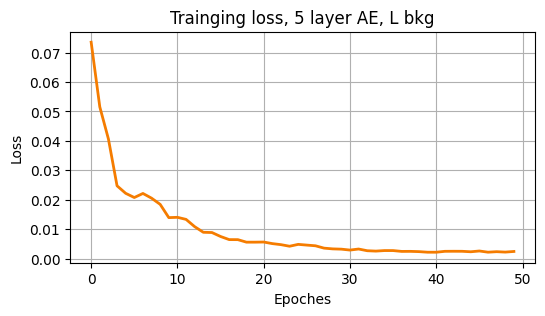

In [57]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2)    
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 5 layer AE, L bkg')
plt.show()

In [163]:
_, decodedTestdata = autoencoder1(trainData)
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError_train = torch.mean((trainData - reconstructedData)**2,dim=1)
MAE_train = ReconstructedError_train.mean()

In [175]:
print(MAE_train.numpy())

0.002257920034136415


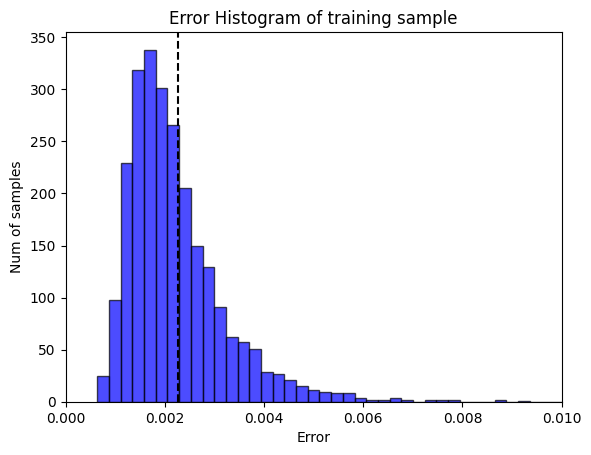

In [165]:
plt.hist(ReconstructedError_train, bins=140,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of training sample')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MAE_train, color = 'black', linestyle = '--')
plt.show()


In [166]:
_, decodedTestdata = autoencoder1(testData)
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError_test = torch.mean((testData - reconstructedData)**2,dim=1)
MAE_test = ReconstructedError_test.mean()

In [176]:
MAE_test.numpy()

array(0.00246625)

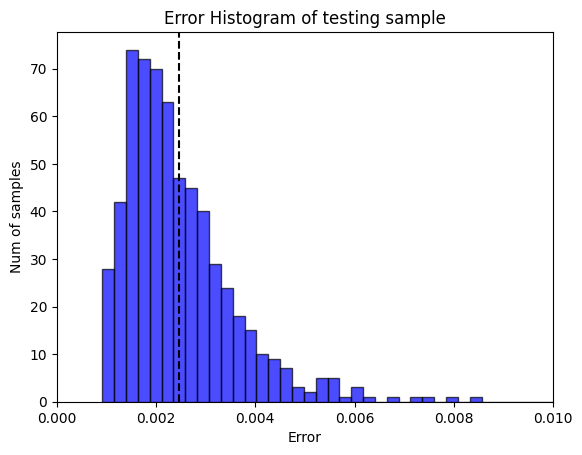

In [168]:
plt.hist(ReconstructedError_test, bins=40,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of testing sample')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MAE_test, color = 'black', linestyle = '--')
plt.show()

In [167]:
np.argwhere(dq['HW_CBC'] == 1)

array([[489],
       [490],
       [491],
       [492],
       [493],
       [494],
       [495],
       [496],
       [497],
       [498],
       [499],
       [500],
       [501],
       [502],
       [503],
       [504],
       [505],
       [506],
       [507],
       [508],
       [509],
       [510],
       [511],
       [512],
       [513],
       [514],
       [515],
       [516],
       [517],
       [518],
       [519],
       [520],
       [521],
       [522],
       [523],
       [524],
       [525],
       [526],
       [527],
       [528],
       [529],
       [530],
       [531],
       [532],
       [533],
       [534],
       [535],
       [536],
       [537],
       [538],
       [539],
       [540],
       [541],
       [542],
       [543],
       [544],
       [545],
       [546],
       [547],
       [548],
       [549],
       [550],
       [551],
       [552],
       [553],
       [554],
       [555],
       [556],
       [557],
       [558],
       [559],
      

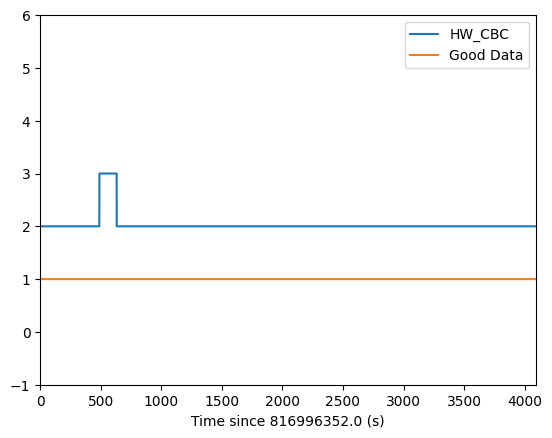

In [51]:
plt.plot(dq['HW_CBC'] + 2, label='HW_CBC')
plt.plot(dq['DEFAULT'], label='Good Data')
plt.xlabel('Time since ' + str(time[0]) + ' (s)')
plt.axis([0, 4096, -1, 6])
plt.legend()
plt.show()

In [94]:
strain_downsampled

array([[-1.70834275e-17, -1.66245424e-17, -1.60716355e-17, ...,
        -2.63369021e-17, -2.84099760e-17, -3.02299732e-17],
       [-3.18333139e-17, -3.32561225e-17, -3.43756223e-17, ...,
         2.09789717e-17,  2.12401406e-17,  2.12935529e-17],
       [ 2.11165172e-17,  2.08219073e-17,  2.03263741e-17, ...,
         1.33861965e-17,  1.58681194e-17,  1.83047568e-17],
       ...,
       [ 1.32676640e-18,  1.43385656e-18,  1.65484036e-18, ...,
         2.27645144e-17,  2.20857537e-17,  2.11606414e-17],
       [ 2.00985779e-17,  1.88909213e-17,  1.74957427e-17, ...,
        -2.04543201e-18, -1.94161868e-18, -1.87115840e-18],
       [-1.95023961e-18, -2.07409288e-18, -2.22788588e-18, ...,
        -3.16452904e-17, -3.27923956e-17, -3.36220306e-17]])

In [75]:
signaled_data = torch.FloatTensor(strain_downsampled_picked_normalized[0:1000])


In [169]:
_, decodedTestdata = autoencoder1(signaled_data)
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError_signal = torch.mean((signaled_data - reconstructedData)**2,dim=1)
MAE_signal = ReconstructedError_signal.mean()

In [177]:
MAE_signal.numpy()

array(0.00242425)

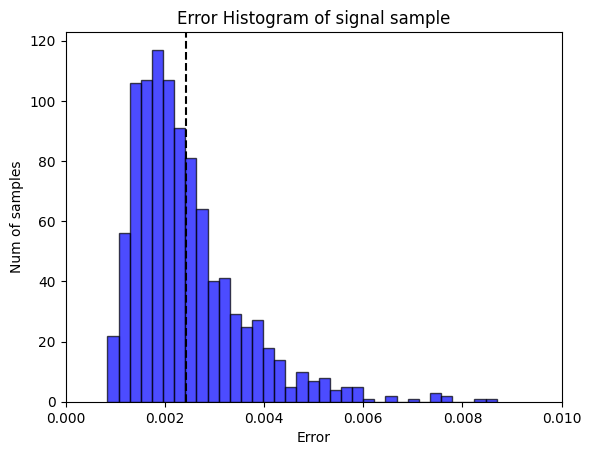

In [171]:
plt.hist(ReconstructedError_signal, bins = 35,facecolor = "blue", edgecolor = "black", alpha = 0.7)
plt.title('Error Histogram of signal sample')
plt.xlim(0,0.01)
plt.xlabel('Error')
plt.ylabel('Num of samples')
plt.axvline(x = MAE_signal, color = 'black', linestyle = '--')
plt.show()

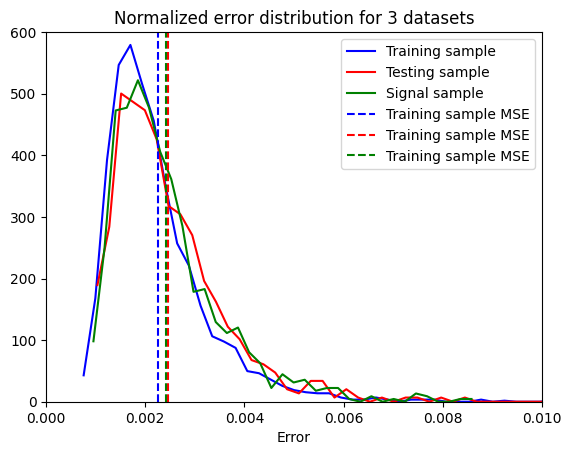

In [172]:
counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = 140, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = 40, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_signal, bins = 35, density = True)
bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
plt.plot(bin_centers_train, counts_train, color = 'blue', label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = 'red', label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = 'green', label = 'Signal sample')
plt.axvline(x = MAE_train, color = 'blue', linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MAE_test, color = 'red', linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MAE_signal, color = 'green', linestyle = '--', label = 'Training sample MSE')
plt.xlim(0, 0.01)
plt.ylim(0, 600)
plt.xlabel('Error')
plt.title('Normalized error distribution for 3 datasets')
plt.legend()
plt.show()

In [92]:

for i in range(1000):
    reconstructedData[i] = reconstructedData[i] * junk2[i] + junk1[i]


In [139]:
strain_downsampled[0:1000].shape

(1000, 1024)

In [145]:
test_sample_number

619

In [146]:
train_sample_number

2477

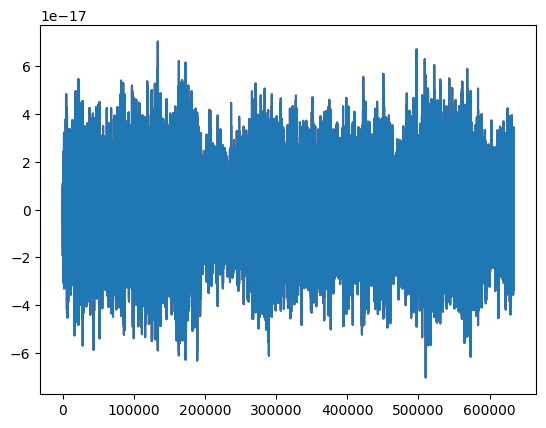

In [163]:
plt.plot(strain_downsampled[3477:4096].flatten(), color = 'red')
y_plot = np.zeros((619,1024))
for i in range(619):
    y_plot[i] = X_test[i] * junk2[i+3477] + junk1[i+3477]
plt.plot(y_plot.flatten(), alpha = 1)

plt.show()

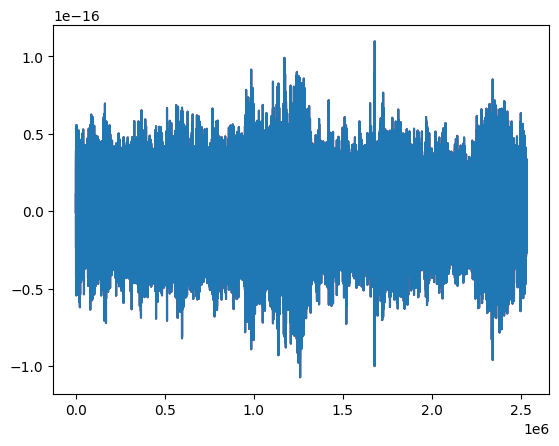

In [164]:
plt.plot(strain_downsampled[1000:3476].flatten(), color = 'red', alpha = 1)
y_plot = np.zeros((2476,1024))
for i in range(2476):
    y_plot[i] = X_train[i] * junk2[i+1000] + junk1[i+1000]
plt.plot(y_plot.flatten())

plt.show()

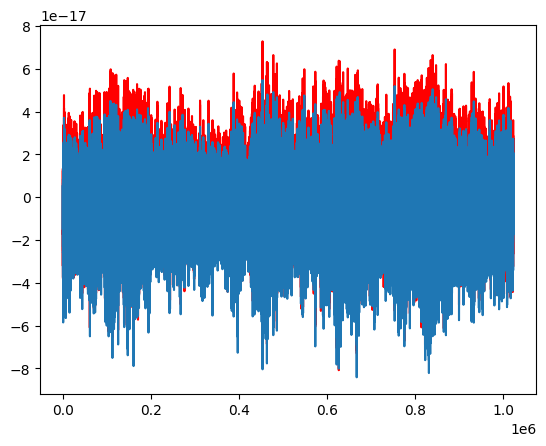

In [93]:
plt.plot(strain_downsampled[0:1000].flatten(), color = 'red')
plt.plot(reconstructedData.flatten())

plt.show()

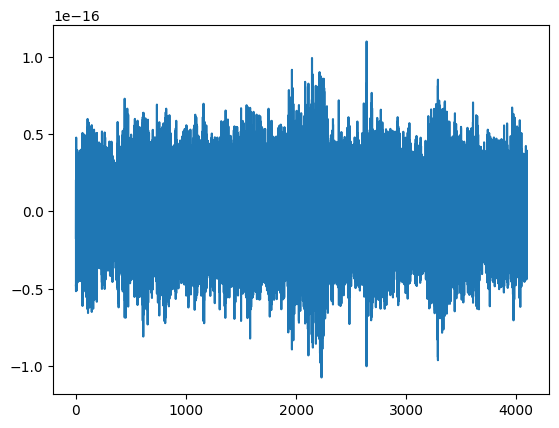

In [166]:
x = np.arange(0,4096,1/1024)
y = strain_downsampled.flatten()
plt.plot(x,y)
plt.
plt.show()

In [32]:
strain_downsampled_picked_tensored = torch.Tensor(strain_downsampled_picked)
_, decodedTestdata = autoencoder(strain_downsampled_picked_tensored)
decodedTestdata = decodedTestdata.double()
reconstructedData = decodedTestdata.detach().numpy()
ReconstructedError = torch.mean((strain_downsampled_picked_tensored - reconstructedData)**2,dim=1)
MAE = ReconstructedError.mean()

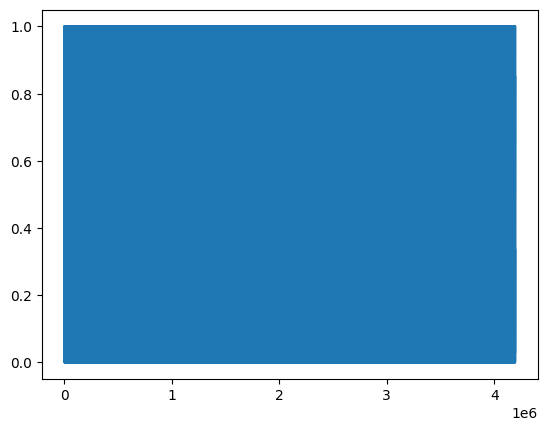

In [33]:
plt.plot(strain_downsampled_picked.flatten())

In [63]:
np.argmax(ReconstructedError)

tensor(2640)

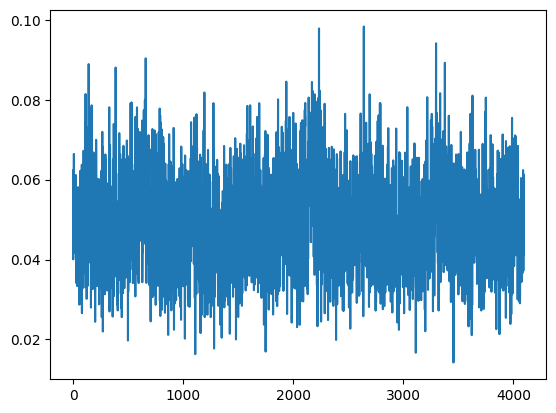

In [34]:
plt.plot(ReconstructedError)

In [47]:
missing_seconds

1186

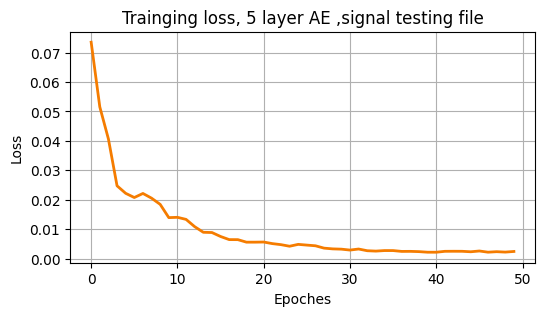

In [94]:
current_time = datetime.datetime.now()
time_string = current_time.strftime("%Y-%m-%d_%H-%M-%S")
os.makedirs(output_dir+time_string+input_file)

output_file_model_name = f"model_{time_string}.pt"
torch.save(autoencoder1, output_dir+time_string+input_file+"/"+output_file_model_name)

parameters = {
    'input_file_name':input_file,
    'vector_length':input_vector_length,
    'num_of_trained_data':train_sample_number,
    'num_of_test_data':test_sample_number,
    'epochs':epochs,
    'batch_size':batch_size
}
output_parameters = pd.DataFrame([parameters]).transpose()
output_parameters.to_csv(output_dir+time_string+input_file+"/"+"parameters_list.csv",header=None)


output_loss_train = pd.DataFrame(loss_train)
output_loss_train.to_csv(output_dir+time_string+input_file+"/"+"loss_train_list.csv",header=None, index=None)

output_reconstructed_error = pd.DataFrame([MAE])
output_reconstructed_error.to_csv(output_dir+time_string+input_file+"/"+"MAE.csv",header=None, index=None)

fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2)    
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 5 layer AE '+ ',signal testing file')
plt.savefig(output_dir+time_string+input_file+"/"+"loss_train_plot.png")

In [ ]:
current_time = datetime.datetime.now()
time_string = current_time.strftime("%Y-%m-%d_%H-%M-%S")
output_file_name = f"model_{time_string}.pt"
torch.save(autoencoder, output_dir+output_file_name)

Now I want to try the Tanh() activation function and -1 1 normalization scheme for the noised sample

In [114]:
class AutoEncoder_Tanh(nn.Module):
    def __init__(self):
        super(AutoEncoder_Tanh, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1024, 768),
            nn.Tanh(),
            nn.Linear(768, 384),
            nn.Tanh(),

        )
        self.decoder = nn.Sequential(
            nn.Linear(384, 768),
            nn.Tanh(),
            nn.Linear(768, 1024),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [125]:
def minus1_1_normalization(v):
    coef = (max(v)-min(v)) / 2
    intercept = (max(v) + min(v)) / 2
    v = (v - intercept) / coef
    return v, intercept, coef

In [126]:
def bunch_minus1_1_normalize(v_set):
    recover_intercept = list(range(len(v_set)))
    recover_coef = list(range(len(v_set)))
    for i in range(len(v_set)):
        v_set[i], recover_intercept[i], recover_coef[i] = minus1_1_normalization(v_set[i])
    return v_set, recover_intercept, recover_coef

In [130]:
strain, time, dq = rl.loaddata("/Volumes/Research/GWNMMAD_data/Test_Data/Injection_from_Ligo/L-L1_LOSC_4_V1-816996352-4096.hdf5")
strain_downsampled = []

average = 0
for j in (range(len(strain))):
    average += strain[j]
    
    if j%4 == 3:
        average = average / 4.
        strain_downsampled.append(average)
        average = 0

strain_downsampled = np.array(strain_downsampled).reshape(-1, 1024)

full_seconds = strain_downsampled.shape[0]
strain_downsampled_picked = strain_downsampled[np.argwhere(dq['DEFAULT'] == 1)].reshape(-1, 1024)
missing_seconds = full_seconds - strain_downsampled_picked.shape[0]

In [131]:
strain_downsampled_picked_normalized, junk1, junk2 = bunch_minus1_1_normalize(strain_downsampled_picked)

In [132]:
data = strain_downsampled_picked_normalized[1000:]

In [133]:
assert data.shape[1] == 1024

total_sample_number = data.shape[0]
test_sample_number = int(test_sample_ratio*total_sample_number)
train_sample_number = total_sample_number-test_sample_number


X_train = data[0:train_sample_number-1]
X_test = data[-test_sample_number:]

X_train, X_train_recover_min, X_train_recover_coef = bunch_normalize(X_train)
X_test, X_test_recover_min, X_test_recover_coef = bunch_normalize(X_test)

trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)


train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


autoencoder2 = AutoEncoder_Tanh()
optimizer = optim.Adam(autoencoder1.parameters(), lr=1e-3)
loss_func = nn.MSELoss()
loss_train = np.zeros((epochs, 1))


for epoch in range(epochs):
    for batchidx, (x, _) in enumerate(trainDataLoader):
        encoded, decoded = autoencoder2(x)
        loss = loss_func(decoded, x) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
           
    loss_train[epoch,0] = loss.item()  
    print('Epoch: %04d, Training loss=%.8f' %
          (epoch+1, loss.item()))

Epoch: 0001, Training loss=0.30703393
Epoch: 0002, Training loss=0.30426249
Epoch: 0003, Training loss=0.30815256
Epoch: 0004, Training loss=0.30744636
Epoch: 0005, Training loss=0.31302205
Epoch: 0006, Training loss=0.30831513
Epoch: 0007, Training loss=0.30686101
Epoch: 0008, Training loss=0.31053060
Epoch: 0009, Training loss=0.30951980
Epoch: 0010, Training loss=0.30885416
Epoch: 0011, Training loss=0.31394973
Epoch: 0012, Training loss=0.31131577
Epoch: 0013, Training loss=0.30864805
Epoch: 0014, Training loss=0.30677274
Epoch: 0015, Training loss=0.30418548
Epoch: 0016, Training loss=0.31075695
Epoch: 0017, Training loss=0.30565381
Epoch: 0018, Training loss=0.30859622
Epoch: 0019, Training loss=0.31109670
Epoch: 0020, Training loss=0.31232285
Epoch: 0021, Training loss=0.30963364
Epoch: 0022, Training loss=0.30889440
Epoch: 0023, Training loss=0.30788603
Epoch: 0024, Training loss=0.31075588
Epoch: 0025, Training loss=0.31077328
Epoch: 0026, Training loss=0.31018028
Epoch: 0027,

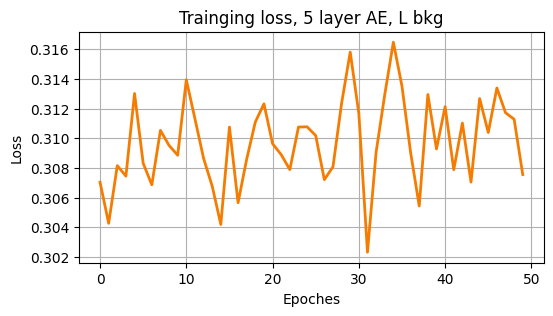

In [134]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2)    
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, 5 layer AE, L bkg')
plt.show()